# 1. Setup and Get Data

## 1.1 Install Dependencies and Setup

In [1]:
!pip install labelme

In [2]:
!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [18 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\jo_bi\AppData\Local\Temp\pip-install-p_t_fxcl\tensorflow-gpu_2ffd0873d23445e4a7651a4764e5acbd\setup.py", line 37, in <module>
      raise Exception(TF_REMOVAL_WARNING)
  Exception:
  
  The "tensorflow-gpu" package has been removed!
  
  Please install "tensorflow" instead.
  
  Other than the name, the two packages have been identical
  since TensorFlow 2.1, or roughly since Sep 2019. For more
  information, see: pypi.org/project/tensorflow-gpu
  
  
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
ERROR: Could not build wheels for tensorflow-gpu, which is required to install pyproject.toml-

In [15]:
import os
import time
import uuid
import cv2

In [16]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [4]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'


In [ ]:
!labelme

# 2. Review Dataset and Build Image Loading Function

## 2.1 Import TF and Deps

In [1]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

## 2.2 Limit GPU Memory Growth

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 2.3 Load Image into TF Data Pipeline

In [4]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [5]:
images.as_numpy_iterator().next()

b'data\\images\\6d243638-a3de-11ee-9a4e-bcf4d4e6c02d.jpg'

In [6]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [7]:
images = images.map(load_image)

In [8]:
images.as_numpy_iterator().next()

array([[[170, 181, 185],
        [170, 181, 185],
        [171, 182, 186],
        ...,
        [184, 194, 195],
        [184, 194, 195],
        [185, 195, 196]],

       [[171, 182, 186],
        [171, 182, 186],
        [171, 182, 186],
        ...,
        [183, 193, 194],
        [183, 193, 194],
        [184, 194, 195]],

       [[171, 182, 186],
        [171, 182, 186],
        [169, 183, 186],
        ...,
        [182, 192, 193],
        [183, 193, 194],
        [183, 193, 194]],

       ...,

       [[159, 168, 167],
        [159, 168, 167],
        [157, 166, 165],
        ...,
        [147, 126, 105],
        [147, 129, 109],
        [148, 130, 110]],

       [[158, 167, 166],
        [159, 168, 167],
        [159, 168, 167],
        ...,
        [144, 123, 102],
        [144, 126, 106],
        [147, 129, 109]],

       [[157, 166, 165],
        [159, 168, 167],
        [161, 170, 169],
        ...,
        [140, 119,  98],
        [140, 122, 102],
        [144, 126, 106]]

In [17]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

## 2.4 View Raw Images with Matplotlib

In [9]:
image_generator = images.batch(4).as_numpy_iterator()

In [10]:
plot_images = image_generator.next()

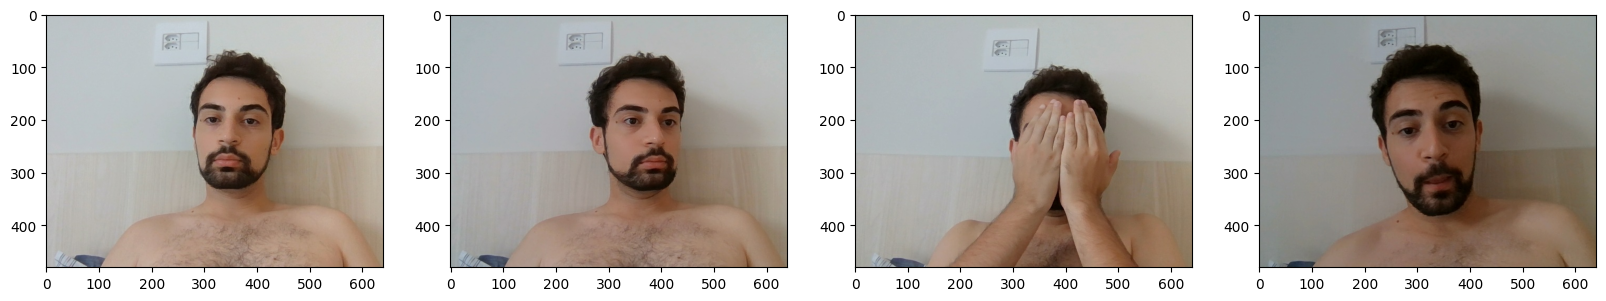

In [11]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

## 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [12]:
90*.7 # 63 to train

62.99999999999999

In [13]:
90*.15 # 14 and 13 to test and val

13.5

## 3.2 Move the Matching Labels

In [17]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)  

# 4. Apply Image Augmentation on Images and Labels using Albumentations

## 4.1 Setup Albumentations Transform Pipeline

In [18]:
import albumentations as alb

In [19]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

## 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [20]:
img = cv2.imread(os.path.join('data','train', 'images','88c93ffe-a3de-11ee-ab9e-bcf4d4e6c02d.jpg'))

In [21]:
with open(os.path.join('data', 'train', 'labels', '88c93ffe-a3de-11ee-ab9e-bcf4d4e6c02d.json'), 'r') as f:
    label = json.load(f)

In [22]:
label['shapes'][0]['points']

[[296.3888888888889, 90.92592592592598],
 [492.68518518518516, 381.66666666666674]]

## 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [23]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [30]:
coords

[296.3888888888889, 90.92592592592598, 492.68518518518516, 381.66666666666674]

In [24]:
coords = list(np.divide(coords, [640,480,640,480]))

In [32]:
coords

[0.46310763888888895,
 0.18942901234567913,
 0.7698206018518519,
 0.7951388888888891]

## 4.4 Apply Augmentations and View Results

In [25]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [26]:
augmented['bboxes'][0][2:]

(0.561358024691358, 0.834814814814815)

In [27]:
augmented['bboxes']

[(0.12514403292181064,
  0.18872427983539106,
  0.561358024691358,
  0.834814814814815)]

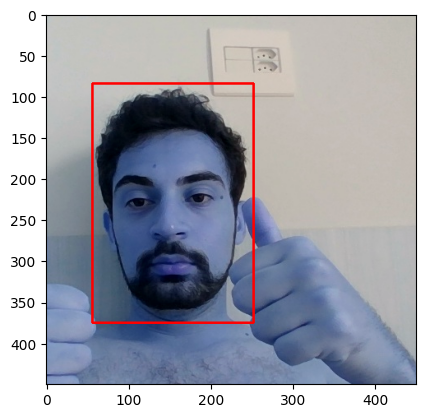

In [28]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

## 5.1 Run Augmentation Pipeline

In [50]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.8262442129629628, 0.8780864197530865, 0.5282118055555556, 0.19714506172839516, 'face'].
x_max is less than or equal to x_min for bbox [0.12311921296296299, 0.9976851851851852, 0.0, 0.7943519395342311, 'face'].


## 5.2 Load Augmented Images to Tensorflow Dataset

In [51]:
def load_augmented(type, shuffle=False, size=(0, 0)):
    images = tf.data.Dataset.list_files('aug_data\\' + type + '\\images\\*.jpg', shuffle=False)
    images = images.map(load_image)
    images = images.map(lambda x: tf.image.resize(x, size))
    images = images.map(lambda x: x/255)

In [52]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [53]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [54]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [55]:
train_images.as_numpy_iterator().next()

array([[[0.41127452, 0.4269608 , 0.42303923],
        [0.4151961 , 0.43088236, 0.4269608 ],
        [0.41568628, 0.43137255, 0.42745098],
        ...,
        [0.4745098 , 0.47843137, 0.45882353],
        [0.47058824, 0.4745098 , 0.45490196],
        [0.47150734, 0.4754289 , 0.45582107]],

       [[0.41617647, 0.43186274, 0.42794117],
        [0.40882352, 0.4245098 , 0.42058823],
        [0.41574755, 0.43143383, 0.42751226],
        ...,
        [0.47401962, 0.4779412 , 0.45833334],
        [0.47058824, 0.4745098 , 0.45490196],
        [0.47205883, 0.4759804 , 0.45637256]],

       [[0.4153799 , 0.4310662 , 0.42714462],
        [0.41525736, 0.43094364, 0.42702207],
        [0.41574755, 0.43143383, 0.42751226],
        ...,
        [0.47058824, 0.4745098 , 0.45490196],
        [0.4745098 , 0.47843137, 0.45882353],
        [0.475     , 0.47892156, 0.45931372]],

       ...,

       [[0.41047794, 0.39871323, 0.37126225],
        [0.40778187, 0.39601716, 0.3685662 ],
        [0.40735295, 0

# 6. Prepare Labels

## 6.1 Build Label Loading Function

In [56]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

## 6.2 Load Labels to Tensorflow Dataset

In [57]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [58]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [59]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [60]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.2451, 0.3247, 0.704 , 0.9565], dtype=float16))

# 7. Combine Label and Image Samples

## 7.1 Check Partition Lengths

In [61]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3660, 3660, 720, 720, 900, 900)

## 7.2 Create Final Datasets (Images/Labels)

In [62]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [63]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [64]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [65]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.02309, 0.1926 , 0.482  , 0.855  ],
        [0.     , 0.1858 , 0.366  , 0.9263 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.4792 , 0.0793 , 0.897  , 0.6494 ],
        [0.404  , 0.2496 , 0.844  , 0.875  ],
        [0.     , 0.1969 , 0.3792 , 0.8267 ],
        [0.3687 , 0.0935 , 0.815  , 0.6943 ],
        [0.3047 , 0.26   , 0.7305 , 0.863  ]], dtype=float16))

## 7.3 View Images and Annotations

In [66]:
data_samples = train.as_numpy_iterator()

In [67]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


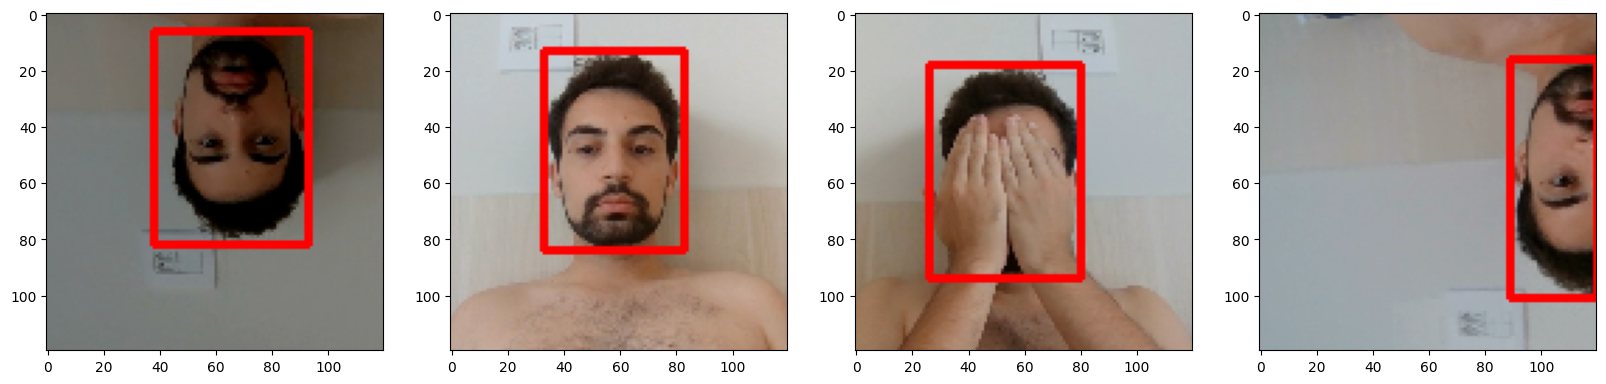

In [87]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    # convert the image to cv::UMat
    sample_image_umat = cv2.UMat(sample_image)

    start_point = tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int))
    end_point = tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int))

    cv2.rectangle(sample_image_umat, start_point, end_point, (255, 0, 0), 2)

    
    # cv2.rectangle(sample_image, 
    #               tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
    #               tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
    #                     (255,0,0), 2)

    sample_image_result = np.array(sample_image_umat.get())
    
    ax[idx].imshow(sample_image_result)

# 8. Build Deep Learning using the Functional API

## 8.1 Import Layers and Base Network

In [88]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

## 8.2 Download VGG16

In [89]:
vgg = VGG16(include_top=False)

In [90]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

## 8.3 Build instance of Network

In [91]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

## 8.4 Test out Neural Network

In [92]:
facetracker = build_model()

In [93]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [94]:
X, y = train.as_numpy_iterator().next()

In [95]:
X.shape

(8, 120, 120, 3)

In [96]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 6s 6s/step


In [97]:
classes, coords

(array([[0.6697071 ],
        [0.622295  ],
        [0.6079497 ],
        [0.7041996 ],
        [0.55835813],
        [0.6637    ],
        [0.66220397],
        [0.6648506 ]], dtype=float32),
 array([[0.46909177, 0.49199522, 0.29411614, 0.507072  ],
        [0.45053178, 0.5078542 , 0.35021585, 0.51047623],
        [0.3570902 , 0.4665642 , 0.43614474, 0.47180095],
        [0.49337295, 0.5364085 , 0.30084816, 0.47228718],
        [0.48832518, 0.43717188, 0.3276285 , 0.42160267],
        [0.43102366, 0.5315787 , 0.38420495, 0.5014659 ],
        [0.50877255, 0.5046701 , 0.3378392 , 0.48755988],
        [0.4912956 , 0.4698717 , 0.3070916 , 0.49703673]], dtype=float32))

# 9. Define Losses and Optimizers

## 9.1 Define Optimizer and LR

In [98]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [99]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

## 9.2 Create Localization Loss and Classification Loss

In [100]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size


In [101]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

## 9.3 Test out Loss Metrics

In [102]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=7.6186395>

In [103]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.49692088>

In [104]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=7.6186395>

# 10. Train Neural Network

## 10.1 Create Custom Model Class

In [105]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [106]:
model = FaceTracker(facetracker)

In [107]:
model.compile(opt, classloss, regressloss)

## 10.2 Train

In [108]:
logdir='logs'

In [109]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [110]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10


458/458 [==============================] - 70s 128ms/step - total_loss: 0.1848 - class_loss: 0.0450 - regress_loss: 0.1623 - val_total_loss: 0.0129 - val_class_loss: 0.0012 - val_regress_loss: 0.0123
Epoch 2/10
458/458 [==============================] - 55s 112ms/step - total_loss: 0.0983 - class_loss: 0.0292 - regress_loss: 0.0837 - val_total_loss: 0.0073 - val_class_loss: 4.1814e-05 - val_regress_loss: 0.0073
Epoch 3/10
458/458 [==============================] - 60s 119ms/step - total_loss: 0.0777 - class_loss: 0.0285 - regress_loss: 0.0634 - val_total_loss: 0.0201 - val_class_loss: 9.7122e-05 - val_regress_loss: 0.0201
Epoch 4/10
458/458 [==============================] - 63s 114ms/step - total_loss: 0.0640 - class_loss: 0.0242 - regress_loss: 0.0519 - val_total_loss: 0.0121 - val_class_loss: 0.0095 - val_regress_loss: 0.0073
Epoch 5/10
458/458 [==============================] - 56s 112ms/step - total_loss: 0.0525 - class_loss: 0.0180 - regress_loss: 0.0435 - val_total_loss: 0.0066 

## 10.3 Plot Performance

In [111]:
hist.history

{'total_loss': [0.005993970204144716,
  0.012455780059099197,
  0.026998374611139297,
  0.010157879441976547,
  0.005433383397758007,
  0.005450170487165451,
  0.0031093356665223837,
  0.0030980478040874004,
  0.003925494849681854,
  0.0017593762604519725],
 'class_loss': [0.004142622463405132,
  1.3768812095804606e-05,
  0.020217668265104294,
  0.0005934905493631959,
  0.00238599581643939,
  1.5586798326694407e-05,
  3.9399681554641575e-05,
  0.0004366279754322022,
  0.0002743532822933048,
  5.2899540605721995e-06],
 'regress_loss': [0.00392265897244215,
  0.01244889572262764,
  0.01688954047858715,
  0.009861133992671967,
  0.004240385722368956,
  0.005442377179861069,
  0.0030896358657628298,
  0.002879733918234706,
  0.003788318019360304,
  0.0017567313043400645],
 'val_total_loss': [0.012890337966382504,
  0.007294129114598036,
  0.020118387416005135,
  0.012099092826247215,
  0.006587810814380646,
  0.02364993840456009,
  0.013194994069635868,
  0.007131063379347324,
  0.00852481

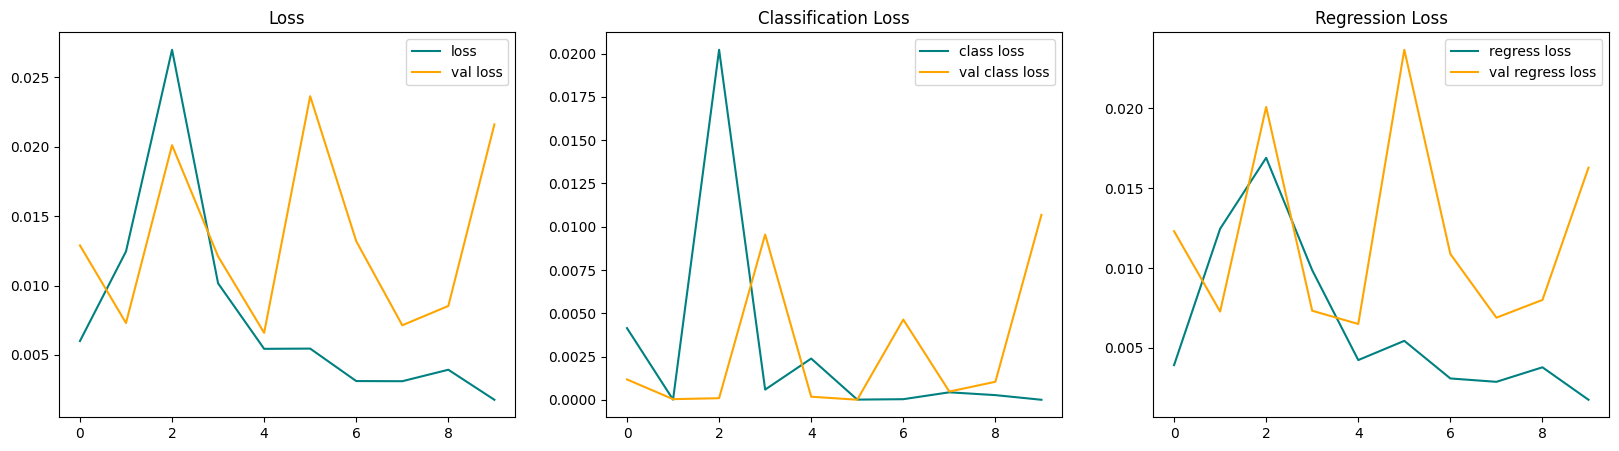

In [112]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

## 11.1 Make Predictions on Test Set

In [113]:
test_data = test.as_numpy_iterator()

In [114]:
test_sample = test_data.next()

In [115]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 35ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


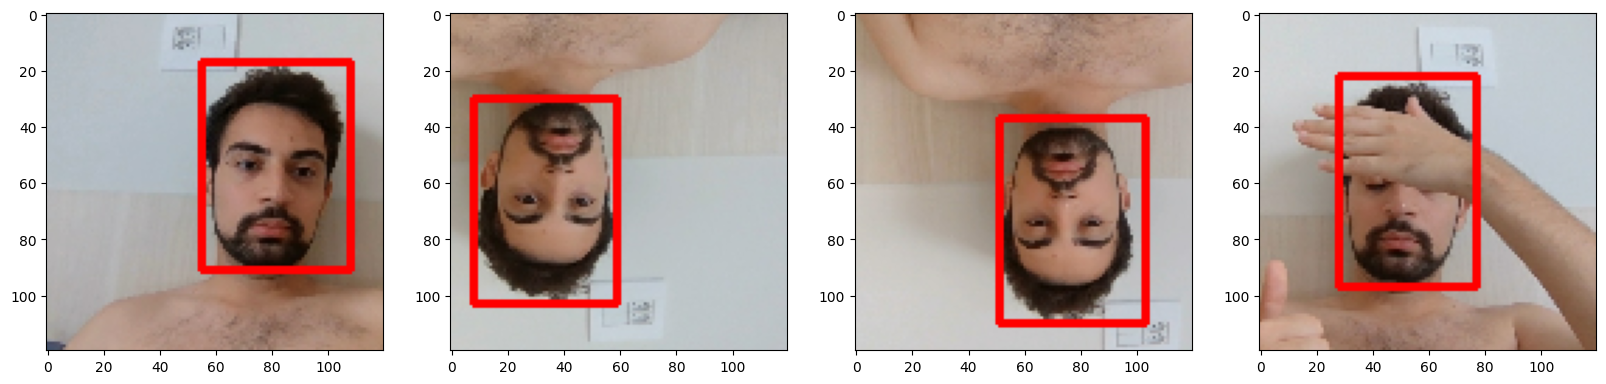

In [117]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        # cv2.rectangle(sample_image, 
        #               tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
        #               tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
        #                     (255,0,0), 2)
        # convert the image to cv::UMat
        sample_image_umat = cv2.UMat(sample_image)

        start_point = tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int))
        end_point = tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int))

        cv2.rectangle(sample_image_umat, start_point, end_point, (255, 0, 0), 2)

        
        # cv2.rectangle(sample_image, 
        #               tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
        #               tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
        #                     (255,0,0), 2)

        sample_image_result = np.array(sample_image_umat.get())
    
    ax[idx].imshow(sample_image_result)
    
    #ax[idx].imshow(sample_image)

## 11.2 Save the Model

In [118]:
from tensorflow.keras.models import load_model

In [119]:
facetracker.save('facetracker.h5')

In [ ]:
facetracker = load_model('facetracker.h5')

## 11.3 Real Time Detection

In [124]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 21ms/step


KeyboardInterrupt: 

In [125]:
cap.release()
cv2.destroyAllWindows()